In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import cv2
from pycrayon import CrayonClient
from torch.utils.data import DataLoader
from faster_rcnn.network import  clip_gradient
import torch

from torch.optim.lr_scheduler import StepLR

In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
from faster_rcnn.utils.data_generator import CocoGenerator
from faster_rcnn.utils.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir, annFile = annFile)




data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


/data
/data/data/mscoco
loading annotations into memory...
Done (t=12.75s)
creating index...
index created!


In [4]:
data = cap[13499]
size = data['tensor'].size()
im = data['tensor']
gt_boxes =  data['boxes']

In [5]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


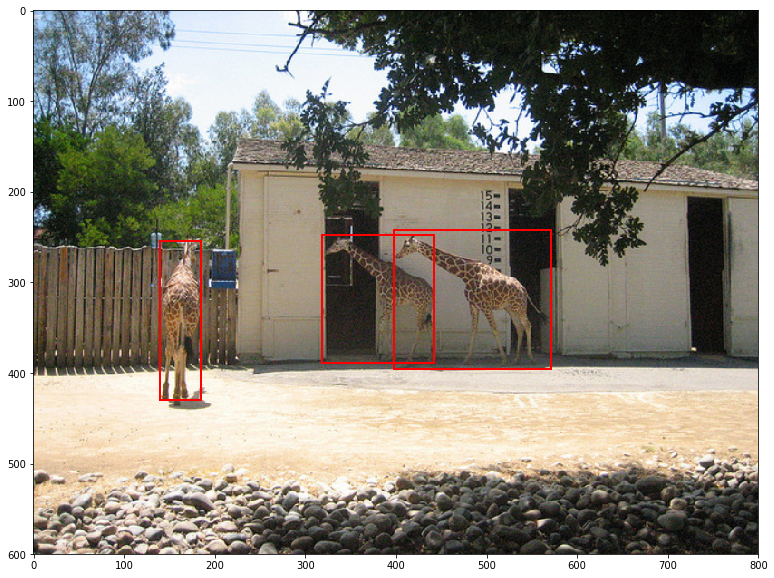

In [6]:
imshow(im[0], gt_boxes)

In [7]:
from faster_rcnn.faster_rcnn import  RPN

In [8]:
cc = CrayonClient(hostname="crayon", port=8889)
try:
    exp = cc.create_experiment("RPN")
except: 
    cc.remove_experiment("RPN")
    exp = cc.create_experiment("RPN")

disp_interval = 100
log_interval = 10

In [8]:
net = RPN()
net.cuda()
net.train()

RPN(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [ ]:
for submodel in net.features.children():
    for param in submodel.parameters():
        param.requires_grad = False

In [9]:
params = filter(lambda x: x.requires_grad, net.parameters())

In [10]:
optimizer = SGD(params, lr=0.001, momentum=0.9)

In [11]:
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)

In [12]:
def train(data_gen, optimizer, lr_scheduler, model, epoch):
    model.train()
    train_loss = 0
    losses = []
    for step in range(1, epoch):
        lr_scheduler.step()
        blobs = data_gen.next()
        if blobs is None:
            continue
        if step > epoch:
            break
        im_data = blobs['tensor']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        output = model(im_data, im_info, gt_boxes)
        loss = model.loss
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(model, 10.)
        optimizer.step()
        loss_value = loss.data.cpu().float()
        losses.append(loss_value)
        
        
        exp.add_scalar_value('current_loss', loss.data[0], step=step)

        if step % disp_interval == 0:

            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

        if step % log_interval == 0:
            exp.add_scalar_value('loss', train_loss /(step) , step=step)
            

In [24]:
train(t, optimizer, exp_lr_scheduler, net, 2)

rpn_cls_score.shape torch.Size([1, 24, 56, 37])
torch.Size([1, 2, 672, 37])
rpn_cls_prob_reshape.shape torch.Size([1, 24, 56, 37])
rpn_bbox_pred torch.Size([1, 48, 56, 37])
rpn_cls_prob_reshape (1, 24, 56, 37)
rpn_bbox_pred (1, 48, 56, 37)
im_size: (899.0, 600.0)
scale: 1.40515220165
height, width 56 37
score map size: (1, 12, 56, 37)
anchors (24864, 4)
proposals shape 1: (24864, 4)
proposals shape 2: (23948, 4)
proposals shape 3: (12000, 4)
DescribeResult(nobs=12000, minmax=(array([ 0.47694838], dtype=float32), array([ 0.97077978], dtype=float32)), mean=array([ 0.56892174], dtype=float32), variance=array([ 0.00597875], dtype=float32), skewness=array([ 1.42480767], dtype=float32), kurtosis=array([ 2.33635187], dtype=float32))
proposals shape 4: (2000, 4)


NameError: global name 'exp' is not defined

In [ ]:
t.next()

In [16]:
torch.save(net.state_dict(), 'rpn.pkl')

In [9]:
net.load_state_dict(torch.load('./rpn.pkl'))


In [10]:
blobs =  cap[13499]
im_data = blobs['tensor']
im_info = blobs['im_info']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])

print gt_boxes.shape

print blobs['boxes'] 
print blobs['image_info']
origin_gt_box =  blobs['boxes']
print origin_gt_box.shape

(3, 5)
[[ 140.    253.75  185.    430.  ]
 [ 318.75  247.5   442.5   388.75]
 [ 397.5   242.5   571.25  395.  ]]
{u'license': 1, u'file_name': u'COCO_train2014_000000309241.jpg', u'coco_url': u'http://mscoco.org/images/309241', u'height': 480, u'width': 640, u'date_captured': u'2013-11-16 12:01:50', u'flickr_url': u'http://farm2.staticflickr.com/1241/992106560_15b6dd2b92_z.jpg', u'id': 309241}
(3, 4)


In [16]:
rois  = net.predict_rois(im_data, im_info)

box_data = rois.data.cpu().numpy()[:, 1:]
box_data.shape

(2000, 4)

In [24]:
np.save(open('rois.np', 'wb'), rois.data.cpu().numpy())

In [17]:
_allowed_border = 0
all_anchors = box_data
inds_inside = np.where(
    (all_anchors[:, 0] >= -_allowed_border) &
    (all_anchors[:, 1] >= -_allowed_border) &
    (all_anchors[:, 2] < im_info[0][1] + _allowed_border) &  # width
    (all_anchors[:, 3] < im_info[0][0] + _allowed_border)  # height
)[0]

print inds_inside

[   0    1    2 ..., 1997 1998 1999]


In [18]:
box_data = box_data[inds_inside]

In [19]:
from faster_rcnn.utils.cython_bbox import bbox_overlaps

print origin_gt_box[:3].shape

overlaps = bbox_overlaps(
    np.ascontiguousarray(box_data, dtype=np.float),
    np.ascontiguousarray(origin_gt_box, dtype=np.float))

argmax_overlaps = overlaps.argmax(axis=0)  # (A)
print overlaps.max(axis=0)
print argmax_overlaps

(3, 4)
[ 0.57797055  0.85006188  0.83075233]
[ 614 1403   51]


In [20]:
sorted_overlap = np.argsort(overlaps, axis=1)
print sorted_overlap.shape
best_overlap_boxes =  sorted_overlap[-3:].flatten()
gt_argmax_overlaps = overlaps.argmax(axis=0)  # G
gt_max_overlaps = overlaps[gt_argmax_overlaps,
                           np.arange(overlaps.shape[1])]
print gt_max_overlaps
print gt_argmax_overlaps

(2000, 3)
[ 0.57797055  0.85006188  0.83075233]
[ 614 1403   51]


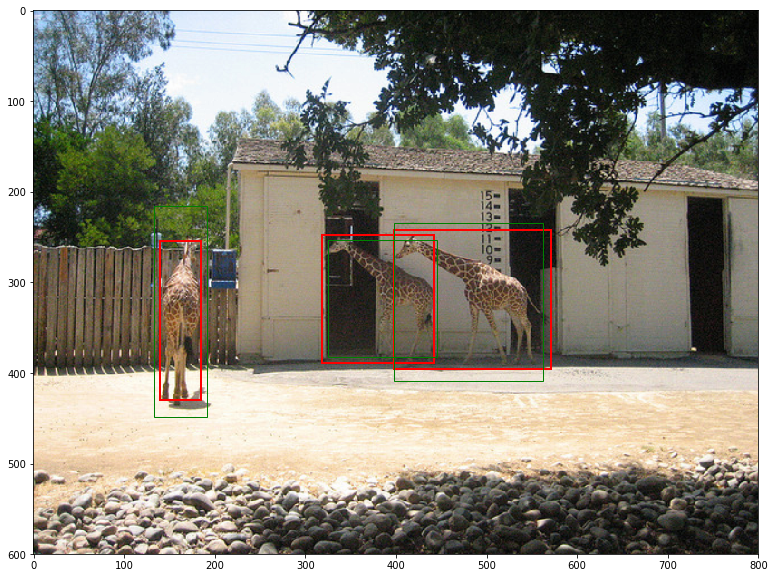

In [23]:
imshow(blobs['tensor'][0], gt_boxes, box_data[gt_argmax_overlaps])